In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from datetime import datetime
import numpy as np
from pytagi.hybrid import *
from tqdm import tqdm

from src.RL_functions.generate_one_synthetic_time_series import generate_datetime_values
from src.RL_functions.kalman_filter import KalmanFilter
from pytagi.nn import LSTM, Linear, Sequential
from scipy.stats import multivariate_normal
from scipy.stats import norm

from examples.data_loader import SyntheticTimeSeriesDataloader, TimeSeriesDataloader

### Datasets overview

In [2]:
# Load the real time series
time_series_path = './data/HQ/CASC_LGA007EFAPRG910_2024_07.mat'
real_data = sio.loadmat(time_series_path)
real_timestamps = real_data['values'][:, 1][0].T[0][540:]
real_obs = real_data['values'][:, 2][0].T[0][540:].tolist()
real_datetime = generate_datetime_values(start_datetime=datetime(2012, 1, 15, 12, 0, 0), num_values=len(real_obs), time_step_interval=7)
datasets_splits = [216, 268, -1]

# Load synthetic time series
syn_observation_save_path='data/CASC_LGA007EFAPRG910_2024_07/RLDS_y_observation_1000episodes_mixed.csv'
syn_datetime_save_path='data/CASC_LGA007EFAPRG910_2024_07/RLDS_y_datetime_1000episodes_mixed.csv'
# Remove the first row in pandas dataframe
syn_obs = pd.read_csv(syn_observation_save_path, skiprows=0, delimiter=",", header=None)
syn_datetime = generate_datetime_values(start_datetime=datetime(2016, 9, 11, 12, 0, 0), num_values=len(syn_obs), time_step_interval=7)

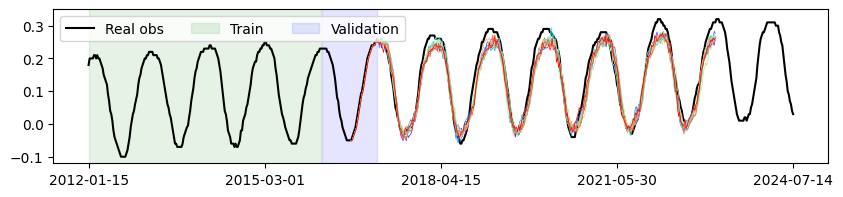

In [3]:
# Plot the real time series
fig = plt.figure(figsize=(10, 2))
plt.plot(real_datetime, real_obs, 'k', label='Real obs')
# Shaded the area between -0.2 and 0.4 for the x range until real_datetime[datasets_splits[0]]
plt.fill_between(real_datetime[:datasets_splits[0]], -0.2, 0.4, color='green', alpha=0.1, label='Train')
plt.fill_between(real_datetime[datasets_splits[0]:datasets_splits[1]], -0.2, 0.4, color='blue', alpha=0.1, label='Validation')

# COLORS = plt.cm.get_cmap('rainbow', 10)
COLORS = plt.colormaps['rainbow'].resampled(10)
for i in range(10):
    plt.plot(syn_datetime, syn_obs[i].tolist(), color = COLORS(i), linewidth=0.5)

plt.legend(loc='upper left', ncol=3)
plt.ylim(-0.12, 0.35)
plt.xticks([real_datetime[0], real_datetime[int(len(real_datetime)/4)], real_datetime[int(len(real_datetime)/2)], real_datetime[int(len(real_datetime)*3/4)], real_datetime[-1]])
plt.gca().set_xticklabels([str(real_datetime[0])[0:10], str(real_datetime[int(len(real_datetime)/4)])[0:10], str(real_datetime[int(len(real_datetime)/2)])[0:10], str(real_datetime[int(len(real_datetime)*3/4)])[0:10], str(real_datetime[-1])[0:10]]);

In [4]:
print(len(syn_datetime))

338


In [5]:
# Preliminary analysis of the synthetic time series
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1
time_covariates = ['week_of_year']

train_dtl = TimeSeriesDataloader(
                            x_file = 'data/CASC_LGA007EFAPRG910_2024_07/ytrain_obs.csv',
                            date_time_file = 'data/CASC_LGA007EFAPRG910_2024_07/ytrain_datetime.csv',
                            output_col = output_col,
                            input_seq_len = input_seq_len,
                            output_seq_len = output_seq_len,
                            num_features = num_features,
                            stride = seq_stride,
                            time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
                        )

train_val_dtl = TimeSeriesDataloader(
                            x_file = 'data/CASC_LGA007EFAPRG910_2024_07/ytrain_yval_obs.csv',
                            date_time_file = 'data/CASC_LGA007EFAPRG910_2024_07/ytrain_yval_datetime.csv',
                            output_col = output_col,
                            input_seq_len = input_seq_len,
                            output_seq_len = output_seq_len,
                            num_features = num_features,
                            x_mean=train_dtl.x_mean,
                            x_std=train_dtl.x_std,
                            stride = seq_stride,
                            time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
                        )

real_ts_dtl = TimeSeriesDataloader(
                            x_file = 'data/CASC_LGA007EFAPRG910_2024_07/y_all_obs.csv',
                            date_time_file = 'data/CASC_LGA007EFAPRG910_2024_07/y_all_datetime.csv',
                            output_col = output_col,
                            input_seq_len = input_seq_len,
                            output_seq_len = output_seq_len,
                            num_features = num_features,
                            x_mean=train_dtl.x_mean,
                            x_std=train_dtl.x_std,
                            stride = seq_stride,
                            time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year', 'day_of_year'
                        )

### HSL probability check

In [6]:
# Time series SSM model
# # LSTM component
LSTM_path = './saved_param/CASC_LGA007EFAPRG910_2024_07/lstm_test1.pth' 
model_path = LSTM_path
net_test = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net_test.set_threads(8)
net_test.load(filename = model_path)

initial_z = np.array([-0.08309378, 0.00077297,0.02])
initial_Sz = np.array([1.00e-05, 1.00e-08, 2.25e-02])

phi_AR = 0.8185086442104763
Sigma_AR = 0.0010854901745454314
AR_var_stationary = Sigma_AR / (1 - phi_AR**2)

sigma_v = 1E-12
var_y = np.full((len(output_col),), sigma_v**2, dtype=np.float32)

ts_model = LSTM_SSM(
                    neural_network = net_test,           # LSTM
                    baseline = 'LT + plain_AR',
                    use_BAR=False,
                    input_BAR=[],
                    zB  = initial_z,
                    SzB = initial_Sz,
                    phi_AR = phi_AR,
                    Sigma_AR = Sigma_AR,
                    Sigma_AA_ratio = None,
                    phi_AA = None,
                    use_auto_AR = False,
                )

syn_ts_dtl = SyntheticTimeSeriesDataloader(
                    x_file=syn_observation_save_path,
                    select_column=0,
                    date_time_file=syn_datetime_save_path,
                    add_anomaly = True,
                    anomaly_magnitude=0.000,
                    # anomaly_magnitude=0.0005,
                    # anomaly_magnitude=np.random.uniform(-0.01, 0.01),
                    # anomaly_start=len(syn_datetime)-input_seq_len-100,
                    anomaly_start=200+input_seq_len,
                    x_mean=train_dtl.x_mean,
                    x_std=train_dtl.x_std,
                    output_col=output_col,
                    input_seq_len=input_seq_len,
                    output_seq_len=output_seq_len,
                    num_features=num_features,
                    stride=seq_stride,
                    time_covariates=time_covariates,
                )

# Drift model
drift_baseline_process_error_var = 1e-10
components_d = ['trend', 'ar']
hyperparameters_d = {'trend': {'process_error_var': drift_baseline_process_error_var, 'phi': 1},
                    'ar': {'phi': phi_AR, 'process_error_var': Sigma_AR},
                    'observation': {'error': 1e-6}}
x_init_d = {'mu': np.array([0, 0.0, 0.02]), \
            'var': np.diag([drift_baseline_process_error_var, drift_baseline_process_error_var, 2.25e-02])}

kf_d = KalmanFilter(components = components_d, time_step=1, hyperparameters = hyperparameters_d)

In [7]:
print(len(syn_datetime))

print(len(syn_datetime)-input_seq_len-100)

338
212


In [8]:
# Get the initial values after running the training and validation sets
batch_iter = train_val_dtl.create_data_loader(batch_size=1, shuffle=False)

mu_preds_lstm = []
var_preds_lstm = []
obs_norm = []

ts_model.init_ssm_hs()

x_ls_d = {'mu': x_init_d['mu'], 'var': x_init_d['var']}

for i, (x, y) in enumerate(batch_iter):
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
        input_seq_len = input_seq_len, num_features = num_features,
        )
    # Feed forward
    y_pred, Sy_pred, z_pred, Sz_pred, m_pred, v_pred = ts_model(mu_x, var_x)
    # Backward
    z_update, Sz_update = ts_model.backward(mu_obs = y, var_obs = var_y, train_LSTM = False)

    mu_preds_lstm.extend(m_pred)
    var_preds_lstm.extend(v_pred)

init_z = ts_model.z
init_Sz = ts_model.Sz
x_init_d['mu'][-1] = init_z[-2]

/var/folders/vv/62ff9wx97g72zr4_20vx1q3h0000gn/T/ipykernel_89042/927143498.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_init_d['mu'][-1] = init_z[-2]


In [9]:
# Get the flexible initial values for drift model
syn_ts_dtl_i = SyntheticTimeSeriesDataloader(
                x_file=syn_observation_save_path,
                select_column=-1,
                date_time_file=syn_datetime_save_path,
                add_anomaly = False,
                x_mean=train_dtl.x_mean,
                x_std=train_dtl.x_std,
                output_col=output_col,
                input_seq_len=input_seq_len,
                output_seq_len=output_seq_len,
                num_features=num_features,
                stride=seq_stride,
                time_covariates=time_covariates,
            )

ts_model = LSTM_SSM(
                    neural_network = net_test,           # LSTM
                    baseline = 'LT + plain_AR',
                    use_BAR=False,
                    input_BAR=[],
                    z_init  = init_z,
                    Sz_init = init_Sz,
                    phi_AR = phi_AR,
                    Sigma_AR = Sigma_AR,
                    Sigma_AA_ratio = None,
                    phi_AA = None,
                    use_auto_AR = False,
                )
mu_preds_lstm_temp = copy.deepcopy(mu_preds_lstm)
var_preds_lstm_temp = copy.deepcopy(var_preds_lstm)

ts_model.init_ssm_hs()
batch_iter = syn_ts_dtl_i.create_data_loader(batch_size=1, shuffle=False)
x_ls_d = {'mu': x_init_d['mu'], 'var': x_init_d['var']}

for i, (x, y) in enumerate(batch_iter):
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm_temp, var_preds_lstm = var_preds_lstm_temp,
        input_seq_len = input_seq_len, num_features = num_features,
        )
    
    ####### Base model #######
    # Feed forward
    y_pred, Sy_pred, z_pred, Sz_pred, m_pred, v_pred = ts_model(mu_x, var_x)
    # Backward
    z_update, Sz_update = ts_model.backward(mu_obs = y, var_obs = var_y, train_LSTM = False)

    mu_preds_lstm_temp.extend(m_pred)
    var_preds_lstm_temp.extend(v_pred)

    ####### Drift model #######
    pred_AR_a, xd_pred_a, _ = kf_d.predict(x_ls_d)
    pred_AR_a['mu'] = pred_AR_a['mu'].item()
    pred_AR_a['var'] = pred_AR_a['var'].item()

    target_AR = {'mu': z_pred[-2], 'var': Sz_pred[-2,-2]}
    cov_x_AR = xd_pred_a['var'] @ kf_d.F.T
    x_ls_d = kf_d.dist_update(target_AR, pred_AR_a, xd_pred_a, cov_x_AR)

x_init_d['var'] = copy.deepcopy(x_ls_d['var'])

In [10]:
# # Estimate stationary drift hidden states parameters (mean and variance)
# num_ts_used_for_estimation = 10
# LTd_AR_samples = []
# AR_pred = []
# for i in tqdm(range(num_ts_used_for_estimation)):
#     syn_ts_dtl_i = SyntheticTimeSeriesDataloader(
#                     x_file=syn_observation_save_path,
#                     select_column=-(2+i),
#                     date_time_file=syn_datetime_save_path,
#                     add_anomaly = False,
#                     x_mean=train_dtl.x_mean,
#                     x_std=train_dtl.x_std,
#                     output_col=output_col,
#                     input_seq_len=input_seq_len,
#                     output_seq_len=output_seq_len,
#                     num_features=num_features,
#                     stride=seq_stride,
#                     time_covariates=time_covariates,
#                 )
    
#     ts_model = LSTM_SSM(
#                         neural_network = net_test,           # LSTM
#                         baseline = 'LT + plain_AR',
#                         use_BAR=False,
#                         input_BAR=[],
#                         z_init  = init_z,
#                         Sz_init = init_Sz,
#                         phi_AR = phi_AR,
#                         Sigma_AR = Sigma_AR,
#                         Sigma_AA_ratio = None,
#                         phi_AA = None,
#                         use_auto_AR = False,
#                     )
#     mu_preds_lstm_temp = copy.deepcopy(mu_preds_lstm)
#     var_preds_lstm_temp = copy.deepcopy(var_preds_lstm)
    
#     ts_model.init_ssm_hs()
#     batch_iter = syn_ts_dtl_i.create_data_loader(batch_size=1, shuffle=False)
#     x_ls_d = copy.deepcopy(x_init_d)

#     for i, (x, y) in enumerate(batch_iter):
#         mu_x, var_x = process_input_ssm(
#             mu_x = x, mu_preds_lstm = mu_preds_lstm_temp, var_preds_lstm = var_preds_lstm_temp,
#             input_seq_len = input_seq_len, num_features = num_features,
#             )
        
#         ####### Base model #######
#         # Feed forward
#         y_pred, Sy_pred, z_pred, Sz_pred, m_pred, v_pred = ts_model(mu_x, var_x)
#         # Backward
#         z_update, Sz_update = ts_model.backward(mu_obs = y, var_obs = var_y, train_LSTM = False)

#         mu_preds_lstm_temp.extend(m_pred)
#         var_preds_lstm_temp.extend(v_pred)

#         ####### Drift model #######
#         pred_AR_a, xd_pred_a, _ = kf_d.predict(x_ls_d)
#         LTd_AR_samples.append(xd_pred_a['mu'][1])
#         pred_AR_a['mu'] = pred_AR_a['mu'].item()
#         pred_AR_a['var'] = pred_AR_a['var'].item()

#         target_AR = {'mu': z_pred[-2], 'var': Sz_pred[-2,-2]}
#         cov_x_AR = xd_pred_a['var'] @ kf_d.F.T
#         x_ls_d = kf_d.dist_update(target_AR, pred_AR_a, xd_pred_a, cov_x_AR)

# x_samples_mean = np.mean(LTd_AR_samples)
# x_samples_cov = np.cov(LTd_AR_samples)

# plt.figure(figsize=(10, 2))
# plt.plot(LTd_AR_samples, 'k', label='LTd_AR_samples')
# plt.ylabel('LTd_AR_samples')

# x_samples_mean, x_samples_cov = -6.563132390993819e-06, 1.9675491949909313e-06 # Process error variance = 1e-6
x_samples_mean, x_samples_cov = -3.5858770870630305e-06, 2.036435068032187e-09  # Process error variance = 1e-10

mv_normal_x = multivariate_normal(mean=x_samples_mean, cov=x_samples_cov, allow_singular=True)
x_init_d['mu'][1] = x_samples_mean
x_init_d['var'][1,1] = x_samples_cov
print(x_samples_mean, x_samples_cov)

-3.5858770870630305e-06 2.036435068032187e-09


In [11]:
# batch_iter = syn_ts_dtl.create_data_loader(batch_size=1, shuffle=False)
batch_iter = real_ts_dtl.create_data_loader(batch_size=1, shuffle=False)

ts_model = LSTM_SSM(
                    neural_network = net_test,           # LSTM
                    baseline = 'LT + plain_AR',
                    use_BAR=False,
                    input_BAR=[],
                    z_init  = init_z,
                    Sz_init = init_Sz,
                    phi_AR = phi_AR,
                    Sigma_AR = Sigma_AR,
                    Sigma_AA_ratio = None,
                    phi_AA = None,
                    use_auto_AR = False,
                )

obs_norm = []
x_likelihood_na_all, x_likelihood_a_all, y_likelihood_na_all, y_likelihood_a_all = [], [], [], []
p_na_I_Yt1 = 0.998
p_a_I_Yt1 = 0.002
p_na_all = []

hidden_state_one_ts = {'mu': [], 'var': []}
hidden_state_one_ts_posterior = {'mu': [], 'var': []}
prediction_one_ts = {'mu': [], 'var': []}
posterior_prediction_one_ts = {'mu': [], 'var': []}
drift_hidden_state_one_ts = {'mu': [], 'var': []}
drift_prediction_one_ts = {'mu': [], 'var': []}

ts_model.init_ssm_hs()

# Remove when using synthetic time series
mu_preds_lstm = []
var_preds_lstm = []
x_init_d = {'mu': np.array([0, 0.0, 0.02]), \
            'var': np.diag([drift_baseline_process_error_var, drift_baseline_process_error_var, 2.25e-02])}

x_ls_d = {'mu': x_init_d['mu'], 'var': x_init_d['var']}

for i, (x, y) in enumerate(batch_iter):
    ############## Store values from last time step ################
    mu_priors_temp, cov_priors_temp, mu_y_pred_temp, var_y_pred_temp, z_temp, Sz_temp, mu_posteriors_temp, cov_posteriors_temp = \
        copy.deepcopy(ts_model.mu_priors), copy.deepcopy(ts_model.cov_priors), copy.deepcopy(ts_model.mu_y_pred), copy.deepcopy(ts_model.var_y_pred), \
        copy.deepcopy(ts_model.z), copy.deepcopy(ts_model.Sz), copy.deepcopy(ts_model.mu_posteriors), copy.deepcopy(ts_model.cov_posteriors)
    x_ls_d_temp = copy.deepcopy(x_ls_d)

    #####################################################
    ####### Likelihood when intervention is taken #######
    #####################################################
    intervention_state = {'mu': copy.deepcopy(ts_model.z), 'var': copy.deepcopy(ts_model.Sz)}
    intervention_state['mu'][0] += x_ls_d_temp['mu'][0]
    intervention_state['mu'][1] += x_ls_d_temp['mu'][1]
    intervention_state['mu'][-2] = x_ls_d_temp['mu'][-1]
    intervention_state['var'][0,0] += x_ls_d_temp['var'][0,0]
    intervention_state['var'][1,1] += x_ls_d_temp['var'][1,1]
    intervention_state['var'][-2,-2] = x_ls_d_temp['var'][-1,-1]

    ts_model.z = intervention_state['mu']
    ts_model.Sz = intervention_state['var']

    x_last_step_d = copy.deepcopy(x_init_d)
    x_last_step_d['mu'][1] = x_samples_mean
    x_last_step_d['mu'][-1] = ts_model.z[-2].item()
    x_last_step_d['var'][-1,-1] = ts_model.Sz[-2,-2]

    ####### Base model #######
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
        input_seq_len = input_seq_len, num_features = num_features,
        )
    # Feed forward
    y_pred, Sy_pred, z_pred, Sz_pred, _, _ = ts_model(mu_x, var_x)

    ####### Drift model #######
    pred_AR_a, xd_pred_a, _ = kf_d.predict(x_last_step_d)
    x_likelihood_a = mv_normal_x.pdf(xd_pred_a['mu'][1])
    x_likelihood_a = x_likelihood_a / mv_normal_x.pdf(x_samples_mean)
    y_likelihood_a = norm.pdf(y, loc=y_pred, scale=np.sqrt(Sy_pred))

    ########################################################
    ####### Likelihood when intervention is not taken ######
    ########################################################
    x_ls_d = {'mu': x_init_d['mu'], 'var': x_init_d['var']}
    x_last_step_d = copy.deepcopy(x_ls_d_temp)

    ts_model.z = copy.deepcopy(z_temp)
    ts_model.Sz = copy.deepcopy(Sz_temp)
    
    ####### Base model #######
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
        input_seq_len = input_seq_len, num_features = num_features,
        )
    # Feed forward
    y_pred, Sy_pred, z_pred, Sz_pred, _, _ = ts_model(mu_x, var_x)

    ####### Drift model #######
    pred_AR_na, xd_pred_na, _ = kf_d.predict(x_last_step_d)
    x_likelihood_na = mv_normal_x.pdf(xd_pred_na['mu'][1])
    x_likelihood_na = x_likelihood_na / mv_normal_x.pdf(x_samples_mean)
    y_likelihood_na = norm.pdf(y, loc=y_pred, scale=np.sqrt(Sy_pred))

    x_likelihood_na_all.append(x_likelihood_na)
    x_likelihood_a_all.append(x_likelihood_a)
    y_likelihood_na_all.append(y_likelihood_na.item())
    y_likelihood_a_all.append(y_likelihood_a.item())

    p_yt_I_Yt1 = y_likelihood_na * x_likelihood_na * p_na_I_Yt1 + y_likelihood_a * x_likelihood_a * p_a_I_Yt1
    p_na_I_Yt = y_likelihood_na * x_likelihood_na * p_na_I_Yt1 / p_yt_I_Yt1
    p_a_I_Yt = y_likelihood_a * x_likelihood_a * p_a_I_Yt1 / p_yt_I_Yt1
    # p_yt_I_Yt1 = x_likelihood_na * p_na_I_Yt1 + x_likelihood_a * p_a_I_Yt1
    # p_na_I_Yt = x_likelihood_na * p_na_I_Yt1 / p_yt_I_Yt1
    # p_a_I_Yt = x_likelihood_a * p_a_I_Yt1 / p_yt_I_Yt1
    p_na_all.append(p_na_I_Yt.item())

    ########################################################
    ######################## Actor  ########################
    ########################################################
    ts_model.mu_priors, ts_model.cov_priors, ts_model.mu_y_pred, ts_model.var_y_pred, ts_model.z, ts_model.Sz, ts_model.mu_posteriors, ts_model.cov_posteriors = \
        copy.deepcopy(mu_priors_temp), copy.deepcopy(cov_priors_temp), copy.deepcopy(mu_y_pred_temp), copy.deepcopy(var_y_pred_temp), \
        copy.deepcopy(z_temp), copy.deepcopy(Sz_temp), copy.deepcopy(mu_posteriors_temp), copy.deepcopy(cov_posteriors_temp)
    x_ls_d = copy.deepcopy(x_ls_d_temp)

    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
        input_seq_len = input_seq_len, num_features = num_features,
        )
    # Feed forward
    y_pred, Sy_pred, z_pred, Sz_pred, m_pred, v_pred = ts_model(mu_x, var_x)
    # Backward
    z_update, Sz_update = ts_model.backward(mu_obs = y, var_obs = var_y, train_LSTM = False)

    mu_preds_lstm.extend(m_pred)
    var_preds_lstm.extend(v_pred)

    hidden_state_one_ts['mu'].append(z_pred.flatten().tolist())
    hidden_state_one_ts['var'].append(Sz_pred.tolist())
    hidden_state_one_ts_posterior['mu'].append(z_update.flatten().tolist())
    hidden_state_one_ts_posterior['var'].append(Sz_update.tolist())
    obs_norm.extend(y)

    # Prior
    y_mu = ts_model.F @ z_pred
    y_var = ts_model.F @ Sz_pred @ ts_model.F.T

    # Posterior
    y_mu_posterior = ts_model.F @ z_update
    y_var_posterior = ts_model.F @ Sz_update @ ts_model.F.T

    prediction_one_ts['mu'].append(y_mu.item())
    prediction_one_ts['var'].append(y_var.item())
    posterior_prediction_one_ts['mu'].append(y_mu_posterior.item())
    posterior_prediction_one_ts['var'].append(y_var_posterior.item())

    ####### Drift model #######
    pred_AR_a, xd_pred_a, _ = kf_d.predict(x_ls_d)
    pred_AR_a['mu'] = pred_AR_a['mu'].item()
    pred_AR_a['var'] = pred_AR_a['var'].item()

    target_AR = {'mu': z_pred[-2], 'var': Sz_pred[-2,-2]}
    cov_x_AR = xd_pred_a['var'] @ kf_d.F.T
    x_ls_d = kf_d.dist_update(target_AR, pred_AR_a, xd_pred_a, cov_x_AR)
    drift_hidden_state_one_ts['mu'].append(x_ls_d['mu'].tolist())
    drift_hidden_state_one_ts['var'].append(x_ls_d['var'].tolist())
    drift_prediction_one_ts['mu'].append(pred_AR_a['mu'])
    drift_prediction_one_ts['var'].append(pred_AR_a['var'])

Text(0, 0.5, 'p(no action)')

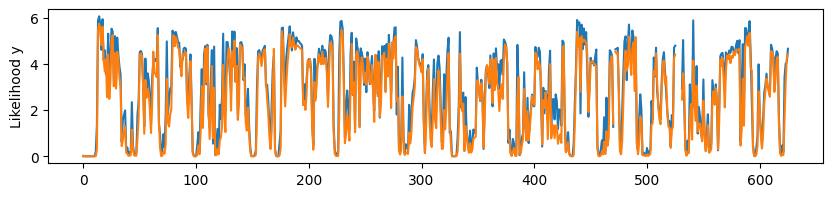

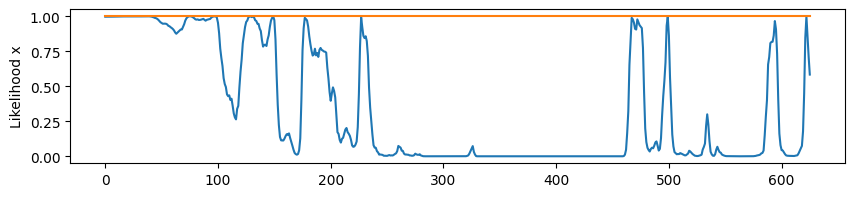

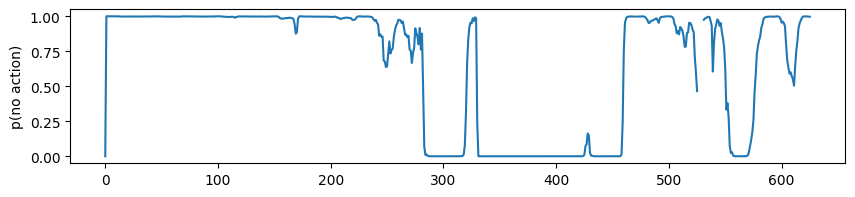

In [12]:
plt.figure(figsize=(10, 2))
plt.plot(y_likelihood_na_all)
plt.plot(y_likelihood_a_all)
plt.ylabel('Likelihood y')

plt.figure(figsize=(10, 2))
plt.plot(x_likelihood_na_all)
plt.plot(x_likelihood_a_all)
plt.ylim(-0.05, 1.05)
plt.ylabel('Likelihood x')

plt.figure(figsize=(10, 2))
plt.plot(p_na_all)
plt.ylim(-0.05, 1.05)
plt.ylabel('p(no action)')

In [13]:
# from matplotlib import gridspec
# fig = plt.figure(figsize=(8, 6))
# gs = gridspec.GridSpec(5, 1)
# ax0 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[1])
# ax2 = plt.subplot(gs[2])
# ax3 = plt.subplot(gs[3])
# ax4 = plt.subplot(gs[4])


# ax0.plot(prediction_one_ts['mu'], 'k')
# ax0.fill_between(range(len(obs_norm)), np.array(prediction_one_ts['mu']) - np.sqrt(np.array(prediction_one_ts['var'])), np.array(prediction_one_ts['mu']) + np.sqrt(np.array(prediction_one_ts['var'])), alpha=0.2)
# ax0.plot(posterior_prediction_one_ts['mu'], 'r')
# ax0.fill_between(range(len(obs_norm)), np.array(posterior_prediction_one_ts['mu']) - np.sqrt(np.array(posterior_prediction_one_ts['var'])), np.array(posterior_prediction_one_ts['mu']) + np.sqrt(np.array(posterior_prediction_one_ts['var'])), alpha=0.2)
# ax0.plot(obs_norm,'--')
# ax0.set_ylabel('Obs')
# ax0.set_xticklabels([])

# ax1.plot(np.transpose(hidden_state_one_ts['mu'])[0], 'k')
# ax1.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[0]) - np.array(hidden_state_one_ts['var'])[:,0,0], np.array(np.transpose(hidden_state_one_ts['mu'])[0]) + np.array(hidden_state_one_ts['var'])[:,0,0], alpha=0.2)
# ax1.plot(np.transpose(hidden_state_one_ts_posterior['mu'])[0], 'r')
# ax1.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts_posterior['mu'])[0]) - np.array(hidden_state_one_ts_posterior['var'])[:,0,0], np.array(np.transpose(hidden_state_one_ts_posterior['mu'])[0]) + np.array(hidden_state_one_ts_posterior['var'])[:,0,0], alpha=0.2)
# ax1.set_ylabel('LL')
# ax1.set_xticklabels([])

# ax2.plot(np.transpose(hidden_state_one_ts['mu'])[1], 'k')
# ax2.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[1]) - np.array(hidden_state_one_ts['var'])[:,1,1], np.array(np.transpose(hidden_state_one_ts['mu'])[1]) + np.array(hidden_state_one_ts['var'])[:,1,1], alpha=0.2)
# ax2.plot(np.transpose(hidden_state_one_ts_posterior['mu'])[1], 'r')
# ax2.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts_posterior['mu'])[1]) - np.array(hidden_state_one_ts_posterior['var'])[:,1,1], np.array(np.transpose(hidden_state_one_ts_posterior['mu'])[1]) + np.array(hidden_state_one_ts_posterior['var'])[:,1,1], alpha=0.2)
# ax2.set_ylim(-0.001, 0.005)
# ax2.set_ylabel('LT')
# ax2.set_xticklabels([])

# ax3.plot(np.transpose(hidden_state_one_ts['mu'])[2], 'k')
# ax3.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[2]) - np.array(hidden_state_one_ts['var'])[:,2,2], np.array(np.transpose(hidden_state_one_ts['mu'])[2]) + np.array(hidden_state_one_ts['var'])[:,2,2], alpha=0.2)
# ax3.plot(np.transpose(hidden_state_one_ts_posterior['mu'])[2], 'r')
# ax3.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts_posterior['mu'])[2]) - np.array(hidden_state_one_ts_posterior['var'])[:,2,2], np.array(np.transpose(hidden_state_one_ts_posterior['mu'])[2]) + np.array(hidden_state_one_ts_posterior['var'])[:,2,2], alpha=0.2)
# ax3.fill_between(range(len(obs_norm)), np.zeros_like(len(obs_norm))-2*np.sqrt(AR_var_stationary), np.zeros_like(len(obs_norm))+2*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
# # ax3.set_ylim(-0.52, 0.52)
# ax3.set_ylabel('AR')
# ax3.set_xticklabels([])

# ax4.plot(np.transpose(hidden_state_one_ts['mu'])[3], 'k', label='Prior')
# ax4.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[3]) - np.array(hidden_state_one_ts['var'])[:,3,3], np.array(np.transpose(hidden_state_one_ts['mu'])[3]) + np.array(hidden_state_one_ts['var'])[:,3,3], alpha=0.2)
# ax4.plot(np.transpose(hidden_state_one_ts_posterior['mu'])[3], 'r', label='Posterior')
# ax4.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts_posterior['mu'])[3]) - np.array(hidden_state_one_ts_posterior['var'])[:,3,3], np.array(np.transpose(hidden_state_one_ts_posterior['mu'])[3]) + np.array(hidden_state_one_ts_posterior['var'])[:,3,3], alpha=0.2)
# ax4.legend(loc='upper left')
# ax4.set_ylabel('LSTM')

# # ax5.plot(np.transpose(drift_hidden_state_one_ts['mu'])[0])
# # ax5.fill_between(range(len(obs_norm)), np.array(np.transpose(drift_hidden_state_one_ts['mu'])[0]) - np.array(drift_hidden_state_one_ts['var'])[:,0,0], np.array(np.transpose(drift_hidden_state_one_ts['mu'])[0]) + np.array(drift_hidden_state_one_ts['var'])[:,0,0], alpha=0.2)
# # ax5.plot(np.transpose(hidden_state_one_ts['mu'])[2])
# # ax5.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[2]) - np.sqrt(np.array(hidden_state_one_ts['var'])[:,2,2]), np.array(np.transpose(hidden_state_one_ts['mu'])[2]) + np.sqrt(np.array(hidden_state_one_ts['var'])[:,2,2]), alpha=0.2)
# # ax5.plot(drift_prediction_one_ts['mu'])
# # ax5.fill_between(range(len(obs_norm)), np.array(drift_prediction_one_ts['mu']) - np.sqrt(np.array(drift_prediction_one_ts['var'])), np.array(drift_prediction_one_ts['mu']) + np.sqrt(np.array(drift_prediction_one_ts['var'])), alpha=0.2)

# # ax6.plot(np.transpose(drift_hidden_state_one_ts['mu'])[1])
# # ax6.fill_between(range(len(obs_norm)), np.array(np.transpose(drift_hidden_state_one_ts['mu'])[1]) - np.array(drift_hidden_state_one_ts['var'])[:,1,1], np.array(np.transpose(drift_hidden_state_one_ts['mu'])[1]) + np.array(drift_hidden_state_one_ts['var'])[:,1,1], alpha=0.2)

Text(0, 0.5, 'p(anm)')

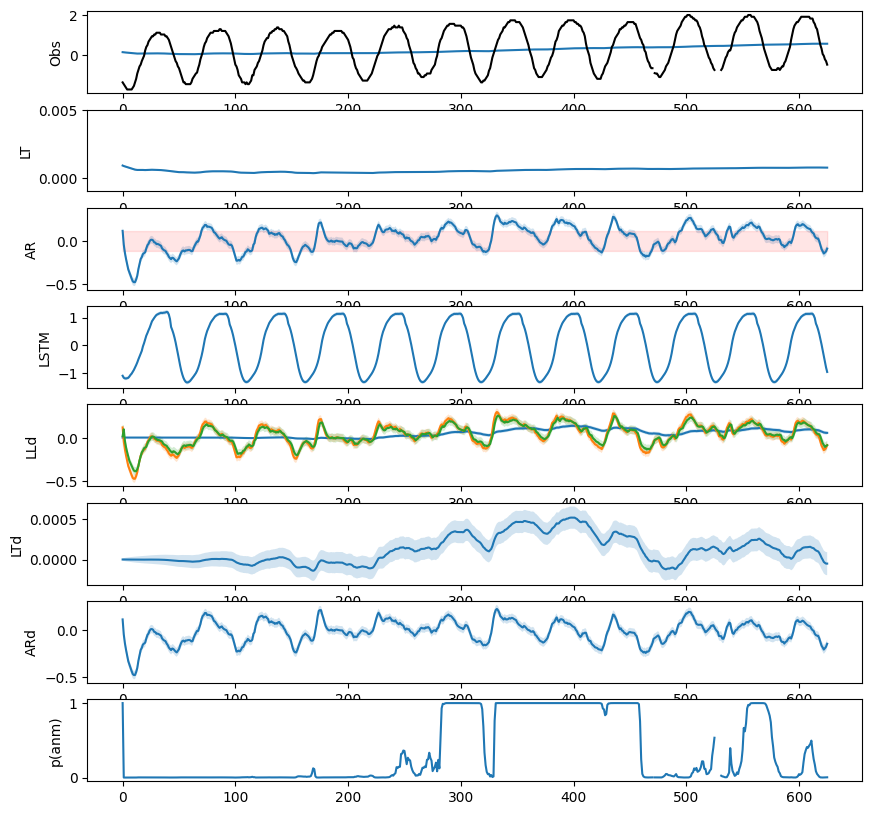

In [17]:
from matplotlib import gridspec
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(8, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])

ax0.plot(np.transpose(hidden_state_one_ts['mu'])[0])
ax0.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[0]) - np.sqrt(np.array(hidden_state_one_ts['var'])[:,0,0]), np.array(np.transpose(hidden_state_one_ts['mu'])[0]) + np.sqrt(np.array(hidden_state_one_ts['var'])[:,0,0]), alpha=0.2)
ax0.plot(obs_norm, 'k')
# ax0.plot(prediction_one_ts['mu'])
# ax0.fill_between(range(len(obs_norm)), np.array(prediction_one_ts['mu']) - np.sqrt(np.array(prediction_one_ts['var'])), np.array(prediction_one_ts['mu']) + np.sqrt(np.array(prediction_one_ts['var'])), alpha=0.2)
ax0.set_ylabel('Obs')

ax1.plot(np.transpose(hidden_state_one_ts['mu'])[1])
ax1.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[1]) - np.sqrt(np.array(hidden_state_one_ts['var'])[:,1,1]), np.array(np.transpose(hidden_state_one_ts['mu'])[1]) + np.sqrt(np.array(hidden_state_one_ts['var'])[:,1,1]), alpha=0.2)
ax1.set_ylim(-0.001, 0.005)
ax1.set_ylabel('LT')

ax2.plot(np.transpose(hidden_state_one_ts['mu'])[2])
ax2.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[2]) - np.sqrt(np.array(hidden_state_one_ts['var'])[:,2,2]), np.array(np.transpose(hidden_state_one_ts['mu'])[2]) + np.sqrt(np.array(hidden_state_one_ts['var'])[:,2,2]), alpha=0.2)
ax2.fill_between(range(len(obs_norm)), np.zeros_like(len(obs_norm))-2*np.sqrt(AR_var_stationary), np.zeros_like(len(obs_norm))+2*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
# ax2.set_ylim(-0.52, 0.52)
ax2.set_ylabel('AR')

ax3.plot(np.transpose(hidden_state_one_ts['mu'])[3])
ax3.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[3]) - np.sqrt(np.array(hidden_state_one_ts['var'])[:,3,3]), np.array(np.transpose(hidden_state_one_ts['mu'])[3]) + np.sqrt(np.array(hidden_state_one_ts['var'])[:,3,3]), alpha=0.2)
ax3.set_ylabel('LSTM')

ax4.plot(np.transpose(drift_hidden_state_one_ts['mu'])[0])
ax4.fill_between(range(len(obs_norm)), np.array(np.transpose(drift_hidden_state_one_ts['mu'])[0]) - np.sqrt(np.array(drift_hidden_state_one_ts['var'])[:,0,0]), np.array(np.transpose(drift_hidden_state_one_ts['mu'])[0]) + np.sqrt(np.array(drift_hidden_state_one_ts['var'])[:,0,0]), alpha=0.2)
ax4.plot(np.transpose(hidden_state_one_ts['mu'])[2])
ax4.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[2]) - np.sqrt(np.array(hidden_state_one_ts['var'])[:,2,2]), np.array(np.transpose(hidden_state_one_ts['mu'])[2]) + np.sqrt(np.array(hidden_state_one_ts['var'])[:,2,2]), alpha=0.2)
ax4.plot(drift_prediction_one_ts['mu'])
ax4.fill_between(range(len(obs_norm)), np.array(drift_prediction_one_ts['mu']) - np.sqrt(np.array(drift_prediction_one_ts['var'])), np.array(drift_prediction_one_ts['mu']) + np.sqrt(np.array(drift_prediction_one_ts['var'])), alpha=0.2)
ax4.set_ylabel('LLd')

ax5.plot(np.transpose(drift_hidden_state_one_ts['mu'])[1])
ax5.fill_between(range(len(obs_norm)), np.array(np.transpose(drift_hidden_state_one_ts['mu'])[1]) - np.sqrt(np.array(drift_hidden_state_one_ts['var'])[:,1,1]), np.array(np.transpose(drift_hidden_state_one_ts['mu'])[1]) + np.sqrt(np.array(drift_hidden_state_one_ts['var'])[:,1,1]), alpha=0.2)
ax5.set_ylabel('LTd')

ax6.plot(np.transpose(drift_hidden_state_one_ts['mu'])[-1])
ax6.fill_between(range(len(obs_norm)), np.array(np.transpose(drift_hidden_state_one_ts['mu'])[-1]) - np.sqrt(np.array(drift_hidden_state_one_ts['var'])[:,-1,-1]), np.array(np.transpose(drift_hidden_state_one_ts['mu'])[-1]) + np.sqrt(np.array(drift_hidden_state_one_ts['var'])[:,-1,-1]), alpha=0.2)
ax6.set_ylabel('ARd')

ax7.plot(range(len(obs_norm)), 1-np.array(p_na_all))
ax7.set_ylim(-0.05, 1.05)
ax7.set_ylabel('p(anm)')

In [15]:
# ts_model = LSTM_SSM(
#                     neural_network = net_test,           # LSTM
#                     baseline = 'LT + plain_AR',
#                     use_BAR=False,
#                     input_BAR=[],
#                     zB  = initial_z,
#                     SzB = initial_Sz,
#                     phi_AR = phi_AR,
#                     Sigma_AR = Sigma_AR,
#                     Sigma_AA_ratio = None,
#                     phi_AA = None,
#                     use_auto_AR = False,
#                 )

# batch_iter = real_ts_dtl.create_data_loader(batch_size=1, shuffle=False)

# mu_preds_lstm = []
# var_preds_lstm = []
# obs_norm = []

# hidden_state_one_ts = {'mu': [], 'var': []}
# prediction_one_ts = {'mu': [], 'var': []}
# drift_hidden_state_one_ts = {'mu': [], 'var': []}
# drift_prediction_one_ts = {'mu': [], 'var': []}

# sigma_v = 1E-12
# var_y = np.full((len(output_col),), sigma_v**2, dtype=np.float32)

# ts_model.init_ssm_hs()

# x_ls_d = {'mu': x_init_d['mu'], 'var': x_init_d['var']}

# for i, (x, y) in enumerate(batch_iter):
#     mu_x, var_x = process_input_ssm(
#         mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
#         input_seq_len = input_seq_len, num_features = num_features,
#         )
#     # Feed forward
#     y_pred, Sy_pred, z_pred, Sz_pred, m_pred, v_pred = ts_model(mu_x, var_x)
#     # Backward
#     z_update, Sz_update = ts_model.backward(mu_obs = y, var_obs = var_y, train_LSTM = False)

#     mu_preds_lstm.extend(m_pred)
#     var_preds_lstm.extend(v_pred)

#     hidden_state_one_ts['mu'].append(z_update.flatten().tolist())
#     hidden_state_one_ts['var'].append(Sz_update.tolist())
#     prediction_one_ts['mu'].append(y_pred.item())
#     prediction_one_ts['var'].append(Sy_pred.item())
#     obs_norm.extend(y)

#     ####### Drift model #######
#     pred_AR_a, xd_pred_a, _ = kf_d.predict(x_ls_d)
#     pred_AR_a['mu'] = pred_AR_a['mu'].item()
#     pred_AR_a['var'] = pred_AR_a['var'].item()

#     target_AR = {'mu': z_pred[-2], 'var': Sz_pred[-2,-2]}
#     cov_x_AR = xd_pred_a['var'] @ kf_d.F.T
#     x_ls_d = kf_d.dist_update(target_AR, pred_AR_a, xd_pred_a, cov_x_AR)
#     drift_hidden_state_one_ts['mu'].append(x_ls_d['mu'].tolist())
#     drift_hidden_state_one_ts['var'].append(x_ls_d['var'].tolist())
#     drift_prediction_one_ts['mu'].append(pred_AR_a['mu'])
#     drift_prediction_one_ts['var'].append(pred_AR_a['var'])

In [16]:
# from matplotlib import gridspec
# fig = plt.figure(figsize=(8, 6))
# gs = gridspec.GridSpec(4, 1)
# ax0 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[1])
# ax2 = plt.subplot(gs[2])
# ax3 = plt.subplot(gs[3])

# ax0.plot(np.transpose(hidden_state_one_ts['mu'])[0])
# ax0.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[0]) - np.array(hidden_state_one_ts['var'])[:,0,0], np.array(np.transpose(hidden_state_one_ts['mu'])[0]) + np.array(hidden_state_one_ts['var'])[:,0,0], alpha=0.2)
# ax0.plot(obs_norm, 'k')
# ax0.plot(prediction_one_ts['mu'])
# ax0.fill_between(range(len(obs_norm)), np.array(prediction_one_ts['mu']) - np.sqrt(np.array(prediction_one_ts['var'])), np.array(prediction_one_ts['mu']) + np.sqrt(np.array(prediction_one_ts['var'])), alpha=0.2)

# ax1.plot(np.transpose(hidden_state_one_ts['mu'])[1])
# ax1.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[1]) - np.array(hidden_state_one_ts['var'])[:,1,1], np.array(np.transpose(hidden_state_one_ts['mu'])[1]) + np.array(hidden_state_one_ts['var'])[:,1,1], alpha=0.2)
# ax1.set_ylim(-0.001, 0.005)

# ax2.plot(np.transpose(hidden_state_one_ts['mu'])[2])
# ax2.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[2]) - np.array(hidden_state_one_ts['var'])[:,2,2], np.array(np.transpose(hidden_state_one_ts['mu'])[2]) + np.array(hidden_state_one_ts['var'])[:,2,2], alpha=0.2)
# ax2.fill_between(range(len(obs_norm)), np.zeros_like(len(obs_norm))-2*np.sqrt(AR_var_stationary), np.zeros_like(len(obs_norm))+2*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
# ax2.fill_between(range(len(obs_norm))[:datasets_splits[0]], -1, 1, color='green', alpha=0.1, label='Train')
# ax2.fill_between(range(len(obs_norm))[datasets_splits[0]:datasets_splits[1]], -1, 1, color='blue', alpha=0.1, label='Validation')
# ax2.set_ylim(-0.52, 0.52)

# ax3.plot(np.transpose(hidden_state_one_ts['mu'])[3])
# ax3.fill_between(range(len(obs_norm)), np.array(np.transpose(hidden_state_one_ts['mu'])[3]) - np.array(hidden_state_one_ts['var'])[:,3,3], np.array(np.transpose(hidden_state_one_ts['mu'])[3]) + np.array(hidden_state_one_ts['var'])[:,3,3], alpha=0.2)
